### Libraries Import

In [85]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import nrrd
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import (
    Input, Conv3D, MaxPooling3D, Concatenate, Add, ReLU, Activation,
    BatchNormalization,GlobalAveragePooling1D, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Reshape, AveragePooling3D
)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
from ipywidgets import interact, IntSlider

### Aux. Functions

In [86]:
def load_data(image_dir, mask_dir):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """
    file_list = []

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        if os.path.exists(mask_path):
            # Ler a máscara para determinar o rótulo
            mask_itk = sitk.ReadImage(mask_path)
            mask_np = sitk.GetArrayFromImage(mask_itk)
            
            # O rótulo é 1 se houver qualquer pixel não-zero na máscara, senão 0
            label = 1 if np.sum(mask_np) > 0 else 0
            
            file_list.append({
                "image": image_path,
                "mask": mask_path,
                "label": label
            })
        else:
            print(f"Aviso: Máscara não encontrada para {image_path}")
            
    return file_list

def load_data_OpenNeuro(image_dir, file_list, label):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação.
    """

    # Garante que os arquivos estão ordenados para o pareamento correto
    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
            
        file_list.append({
            "image": image_path,
            "mask": None,
            "label": label
        })
            
    return file_list

In [87]:
def build_cnn_encoder(input_shape=(150, 150, 150, 2)):
    inputs = Input(shape=input_shape)
    
    # Bloco 1
    conv1 = Conv3D(8, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling3D(pool_size=2)(conv1)
    pool1 = Dropout(0.3)(pool1)

    # Bloco 2
    conv2 = Conv3D(16, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling3D(pool_size=2)(conv2)
    pool2 = Dropout(0.3)(pool2)

    # Bloco 3
    conv3 = Conv3D(32, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling3D(pool_size=2)(conv3)
    pool3 = Dropout(0.3)(pool3)

    # Bloco 4
    conv4 = Conv3D(64, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling3D(pool_size=2)(conv4)
    pool4 = Dropout(0.3)(pool4)

    # Bloco 5
    conv5 = Conv3D(128, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(128, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    multiscale_features = [conv3, conv4, conv5]
    
    encoder = Model(inputs, multiscale_features, name="cnn_multiscale_encoder")
    return encoder

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization()
        self.dropout1 = Dropout(rate)
        self.layernorm2 = LayerNormalization()
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        # --- Pre-Layer Norm 1 ---
        inputs_norm1 = self.layernorm1(inputs) 
        attn_output = self.att(inputs_norm1, inputs_norm1)
        # ----------------------
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        # --- Pre-Layer Norm 2 ---
        out1_norm2 = self.layernorm2(out1)
        ffn_output = self.ffn(out1_norm2)
        # ----------------------

        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output
    
def build_hybrid_transformer_classifier(
    input_shape=(150, 150, 150, 2), 
    num_transformer_blocks=4,
    num_heads=4,
    embed_dim=448,
    ff_dim=448):

    encoder = build_cnn_encoder(input_shape)
    image_input = Input(shape=input_shape)
    features_list = encoder(image_input)

    resized_features = []
    resized_features.append(AveragePooling3D(pool_size=4)(features_list[0])) 
    resized_features.append(AveragePooling3D(pool_size=2)(features_list[1])) 
    resized_features.append(features_list[2])

    # ... depois de concatenar os features ...
    concatenated_features = Concatenate(axis=-1)(resized_features)

    # Achatamento
    seq_length = concatenated_features.shape[1] * concatenated_features.shape[2] * concatenated_features.shape[3]
    reshaped_features = Reshape((seq_length, concatenated_features.shape[-1]))(concatenated_features)

    # Projeta os features da CNN para o espaço de embedding do Transformer
    projection = Dense(embed_dim, name="feature_projection")(reshaped_features)

    # 1. Criar o token CLS como um vetor aprendível
    cls_token = tf.Variable(tf.random.normal(shape=[1, 1, embed_dim]), trainable=True, name="cls_token")

    # 2. Replicar o CLS token para cada item no batch
    batch_size = tf.shape(projection)[0]
    cls_token_broadcasted = tf.broadcast_to(cls_token, [batch_size, 1, embed_dim])

    # 3. Concatenar o CLS token no início da sequência de patches
    x = Concatenate(axis=1)([cls_token_broadcasted, projection])

    # 4. Adicionar o positional embedding a TODOS os tokens (CLS + patches)
    positional_embedding = layers.Embedding(input_dim=seq_length + 1, output_dim=embed_dim)(tf.range(seq_length + 1))
    x = x + positional_embedding

    # ... (passa pelos blocos Transformer normalmente) ...
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    cls_output = x[:, 0]  # Shape: (batch, embed_dim)

    x = Dropout(0.3)(cls_output)
    x = Dense(ff_dim, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=image_input, outputs=outputs)
    return model

In [88]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


### Carregamento das imagens

In [89]:
# Carregar os pares de caminhos
IMAGE_DIR = "Patients_Displasya/T1"
IMAGE_DIR_CONTROL_OPENNEURO = "Patients_Control_OpenNeuro/T1"
IMAGE_DIR_DISPLASYA_OPENNEURO = "Patients_Displasya_OpenNeuro/T1"

MASK_DIR = "Mascaras"
file_list_original = load_data(IMAGE_DIR, MASK_DIR)
file_list = load_data_OpenNeuro(IMAGE_DIR_CONTROL_OPENNEURO, [], 0)
file_list = load_data_OpenNeuro(IMAGE_DIR_DISPLASYA_OPENNEURO, file_list, 1)

### Divisão das classes

In [90]:
# Verificar o balanceamento das classes
labels = [item['label'] for item in file_list]
print(f"Total de amostras encontradas: {len(file_list)}")
print(f"Amostras com lesão (label 1): {np.sum(labels)}")
print(f"Amostras saudáveis (label 0): {len(labels) - np.sum(labels)}")

train_files, val_files = train_test_split(file_list, test_size=0.25, random_state=42, stratify=labels)

print(f"Amostras de treino: {len(train_files)}")
print(f"Amostras de validação: {len(val_files)}")
print(f"Amostras de teste: {len(file_list_original)}")

Total de amostras encontradas: 170
Amostras com lesão (label 1): 85
Amostras saudáveis (label 0): 85
Amostras de treino: 127
Amostras de validação: 43
Amostras de teste: 41


### Preparação do modelo + Treinamento

In [91]:
INPUT_SHAPE = (150, 150, 150, 2)

# Construir o modelo híbrido
model = build_hybrid_transformer_classifier(
    input_shape=INPUT_SHAPE
)

model.summary()

The following Variables were used a Lambda layer's call (tf.broadcast_to_7), but
are not present in its tracked objects:
  <tf.Variable 'cls_token:0' shape=(1, 1, 448) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 150, 150, 15 0                                            
__________________________________________________________________________________________________
cnn_multiscale_encoder (Functio [(None, 37, 37, 37,  849352      input_16[0][0]                   
__________________________________________________________________________________________________
average_p

In [92]:
# Defina o shape final desejado
TARGET_SHAPE_3D = (150, 150, 150)

def load_and_preprocess_image(image_path, label):
    def _read_and_resize_nifti(path):
        # Decodificar o tensor de bytes para uma string Python
        path = path.numpy().decode('utf-8')
        
        nifti_image = nib.load(path).get_fdata().astype(np.float32)
        
        # Obter a forma original e calcular o fator de zoom para cada eixo
        original_shape = nifti_image.shape
        zoom_factors = [
            TARGET_SHAPE_3D[0] / original_shape[0],
            TARGET_SHAPE_3D[1] / original_shape[1],
            TARGET_SHAPE_3D[2] / original_shape[2]
        ]
        
        resized_image = zoom(nifti_image, zoom_factors, order=1)
        
        return resized_image

    image = tf.py_function(
        func=_read_and_resize_nifti, 
        inp=[image_path], 
        Tout=tf.float32
    )
    
    image.set_shape(TARGET_SHAPE_3D)
    
    # O resto do pré-processamento continua igual
    image = tf.expand_dims(image, axis=-1)
    image = tf.repeat(image, repeats=INPUT_SHAPE[3], axis=-1)
    image = image / (tf.reduce_max(image) + 1e-6) 
    image.set_shape(INPUT_SHAPE)
    
    return image, label

# Extrair os caminhos e rótulos das nossas listas
train_paths = [item['image'] for item in train_files]
train_labels = [item['label'] for item in train_files]
val_paths = [item['image'] for item in val_files]
val_labels = [item['label'] for item in val_files]
test_paths = [item['image'] for item in file_list_original]
test_labels = [item['label'] for item in file_list_original]

# Definir o batch_size
batch_size = 2

# Criar o dataset de treino com .batch()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [93]:
# Compilando o modelo híbrido
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Histórico do treinamento
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100)

print("Treinamento concluído.")

Epoch 1/100
64/64 [==============================] - 36s 482ms/step - loss: 1.3812 - accuracy: 0.4724 - precision: 0.4762 - recall: 0.4688 - val_loss: 1.6740 - val_accuracy: 0.4884 - val_precision: 0.4884 - val_recall: 1.0000
Epoch 2/100
64/64 [==============================] - 45s 628ms/step - loss: 1.1604 - accuracy: 0.4094 - precision: 0.4225 - recall: 0.4688 - val_loss: 1.1357 - val_accuracy: 0.5116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
64/64 [==============================] - 45s 625ms/step - loss: 1.1938 - accuracy: 0.4409 - precision: 0.4386 - recall: 0.3906 - val_loss: 0.9216 - val_accuracy: 0.5116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
64/64 [==============================] - 47s 655ms/step - loss: 1.0773 - accuracy: 0.4882 - precision: 0.4930 - recall: 0.5469 - val_loss: 0.7658 - val_accuracy: 0.4884 - val_precision: 0.4884 - val_recall: 1.0000
Epoch 5/100
64/64 [==============================] - 46s 636ms/step - loss: 0.88

### Avaliação do treinamento do modelo

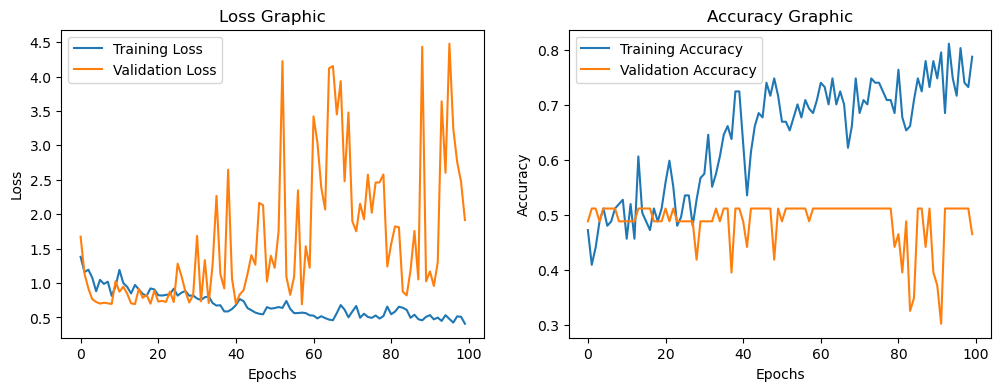

In [94]:
plot_training_history(history)

Validação:
              precision    recall  f1-score   support

           0       0.48      0.64      0.55        22
           1       0.43      0.29      0.34        21

    accuracy                           0.47        43
   macro avg       0.46      0.46      0.45        43
weighted avg       0.46      0.47      0.45        43


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.15      0.26        41

    accuracy                           0.15        41
   macro avg       0.50      0.07      0.13        41
weighted avg       1.00      0.15      0.26        41

Validação:


c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\miniconda3\envs\displasia\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


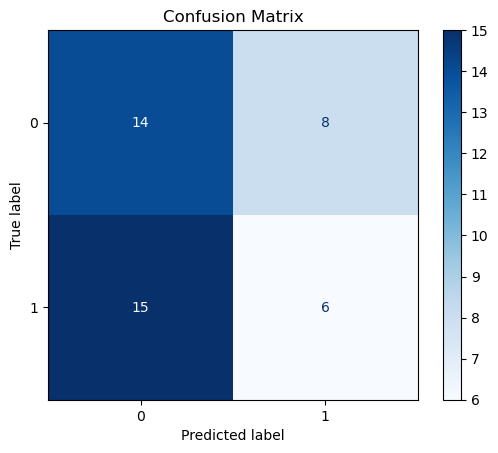

Teste:


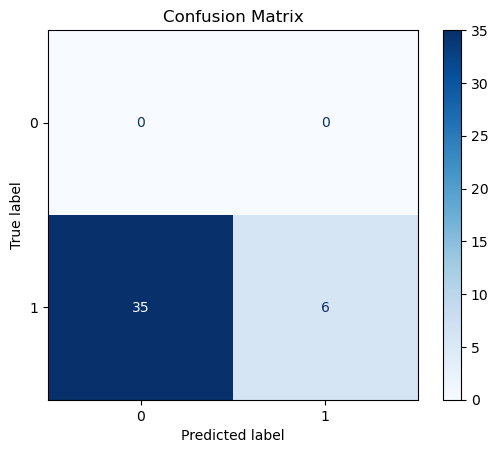

In [95]:
# Avaliar o modelo na validação e teste
y_pred_valid = (model.predict(val_dataset) > 0.5).astype(int)
y_pred_test = (model.predict(test_dataset) > 0.5).astype(int)

# Gerar o relatório de classificação
print("Validação:")
print(classification_report(val_labels, y_pred_valid))
print("\n#########################################################\n")

print("Teste:")
print(classification_report(test_labels, y_pred_test)) 

# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(val_labels, y_pred_valid)
print("Teste:")
plot_confusion_matrix(test_labels, y_pred_test)

### Plot em PDF das Predições

In [96]:
# Para garantir que os plots apareçam no notebook
%matplotlib inline 

def view_interactive_slices(dataset, y_true, y_pred, patient_index):
    """
    Cria um visualizador interativo com slider para um paciente específico.
    
    Args:
        dataset (tf.data.Dataset): Dataset de onde extrair as imagens.
        y_true (list or np.array): Lista de rótulos verdadeiros.
        y_pred (np.array): Array de rótulos preditos.
        patient_index (int): O índice do paciente/volume que você quer visualizar.
    """
    
    # 1. Encontrar a imagem correta no dataset
    # O .unbatch() desfaz os lotes para acessarmos as imagens individualmente
    image_3d_tensor = next(iter(dataset.unbatch().skip(patient_index).take(1)))[0]
    image_3d = image_3d_tensor.numpy()
    
    # 2. Obter os rótulos
    true_label = np.array(y_true)[patient_index]
    predicted_label = y_pred[patient_index][0]

    # 3. Extrair informações da imagem
    num_slices = image_3d.shape[2]
    
    # 4. Definir a função que será chamada pelo slider
    # Esta função será executada toda vez que o valor do slider mudar.
    def plot_slice(slice_index):
        # Seleciona e prepara a fatia 2D
        image_slice_2d = image_3d[:, :, slice_index, 0]
        image_slice_2d = np.rot90(image_slice_2d)
        
        # Cria a plotagem
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image_slice_2d, cmap='gray')
        
        # Título principal
        title_text = f"Paciente #{patient_index} | Predito: {predicted_label} | Verdadeiro: {true_label}"
        color = 'green' if predicted_label == true_label else 'red'
        ax.set_title(title_text, color=color, fontsize=16)
        
        # Título da fatia
        ax.text(5, 15, f"Fatia: {slice_index}/{num_slices-1}", color='white', 
                bbox=dict(facecolor='black', alpha=0.5))
        
        ax.axis('off')
        plt.show()

    # 5. Criar e conectar o slider à função de plotagem
    interact(plot_slice, 
             slice_index=IntSlider(value=num_slices//2, min=0, max=num_slices-1, step=1, description='Fatia:'));


In [97]:
for i in range (len(val_files)):
    view_interactive_slices(val_dataset, val_labels, y_pred_valid, i)

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

In [98]:
for i in range (len(file_list_original)):
    view_interactive_slices(test_dataset, test_labels, y_pred_test, i)

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=75, description='Fatia:', max=149), Output()), _dom_classes=('widget-int…